In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
X_train_resampled = pd.read_csv('X_train_smoteenn.csv')
y_train_resampled = pd.read_csv('y_train_smoteenn.csv')
# double check if the data is correct
X_train_resampled.head(5)

,perc_premium_paid_by_cash_credit,age_in_days,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,premium,logIncome,sourcing_channel_A,sourcing_channel_B,sourcing_channel_C,sourcing_channel_D,sourcing_channel_E,residence_area_type_Rural,residence_area_type_Urban
0,0.917,17531.0,2.0,3.0,1.0,98.69,7.0,3300.0,4.925003,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,1.000,21911.0,1.0,6.0,4.0,99.33,3.0,9600.0,5.255851,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.908,23008.0,2.0,0.0,0.0,98.91,11.0,5400.0,5.030114,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.000,11687.0,1.0,2.0,1.0,99.53,5.0,9600.0,5.183583,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.326,17895.0,0.0,0.0,0.0,98.79,11.0,1200.0,5.301139,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [3]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
scaler.fit(X_train_resampled.as_matrix())
X_scaled = scaler.transform(X_train_resampled)

In [4]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from keras.callbacks import EarlyStopping

/Users/jessie/anaconda3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
def create_baseline(n_features):
    # create model
    model = Sequential()
    model.add(Dense(2*n_features, input_dim=n_features, kernel_initializer='normal', activation='sigmoid'))
    model.add(Dense(n_features, input_dim=2*n_features, kernel_initializer='normal', activation='sigmoid'))
    model.add(Dense(n_features//2, input_dim=n_features, kernel_initializer='normal', activation='sigmoid'))
    model.add(Dense(n_features, input_dim=n_features//2, kernel_initializer='normal', activation='sigmoid'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [6]:
def fit_and_roc(name,x_train, y_train, x_valid, y_valid):
    # fit model using SVM, ANN or Random Forest
    # input name: string, specify the name of machine learning model to be applied
    #       x_train, y_train, x_valid, y_valid: dataframe for training and validation
    # output(the function will automaticlly plot AUC curve) model: a model object with "predict" function
    if name == "ann":
        n_features = x_train.shape[1]
        model = create_baseline(n_features)
        callback = EarlyStopping("val_loss", patience=1, verbose=0, mode='auto')
        model.fit(
                X_train, y_train,
                nb_epoch=20, batch_size=25,
                validation_data=(X_valid, y_valid),
                callbacks=[callback], verbose = 1)
    elif name == 'svm':
        model = svm.SVC(probability=True)
        model.fit(x_train, y_train)
    elif name == 'rf':
        model = RandomForestRegressor(n_jobs=2, n_estimators=150)
        model.fit(x_train, y_train)
        # evaluate training error
    y_train_pred = model.predict(x_train)
    y_train_prob = model.predict_proba(x_train)[:, 0]

    fpr, tpr, thresholds = roc_curve(y_train, y_train_prob, pos_label=1)
    if name == 'svm':
        fpr = 1-fpr
        tpr = 1-tpr
    roc_auc = auc(fpr, tpr)
    
    # evaluate testing error
    y_test_pred = model.predict(x_valid)
    y_test_prob = model.predict_proba(x_valid)[:, 0]
    
    fpr_test, tpr_test, threshold_test = roc_curve(y_valid, y_test_prob, pos_label=1)
    if name == 'svm':
        fpr_test = 1-fpr_test
        tpr_test = 1-tpr_test
    roc_auc_test = auc(fpr_test, tpr_test)
    
    # plot roc
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, \
             color='darkorange', lw=2, linestyle='-', label='Training ROC Curve (area = {0:.2f})'.format(roc_auc))
    plt.plot(fpr_test, tpr_test, \
             color='deeppink', lw=2, linestyle='-', label='Testing ROC Curve (area = {0:.2f})'.format(roc_auc_test))
    plt.plot([0,1], [0,1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

    return model

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X_scaled, y_train_resampled['renewal'].values, random_state=666, train_size=0.80)

/Users/jessie/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


/Users/jessie/anaconda3/lib/python3.5/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 96581 samples, validate on 24146 samples
Epoch 1/20
96581/96581 [==============================] - 15s 153us/step - loss: 0.4540 - acc: 0.7906 - val_loss: 0.3875 - val_acc: 0.8327
Epoch 2/20
96581/96581 [==============================] - 15s 153us/step - loss: 0.3819 - acc: 0.8342 - val_loss: 0.3778 - val_acc: 0.8383
Epoch 3/20
96581/96581 [==============================] - 15s 152us/step - loss: 0.3766 - acc: 0.8347 - val_loss: 0.3731 - val_acc: 0.8401
Epoch 4/20
96581/96581 [==============================] - 15s 151us/step - loss: 0.3744 - acc: 0.8362 - val_loss: 0.3731 - val_acc: 0.8377
Epoch 5/20
96581/96581 [==============================] - 15s 155us/step - loss: 0.3729 - acc: 0.8372 - val_loss: 0.3707 - val_acc: 0.8403
Epoch 6/20
96581/96581 [==============================] - 15s 154us/step - loss: 0.3721 - acc: 0.8371 - val_loss: 0.3804 - val_acc: 0.8360


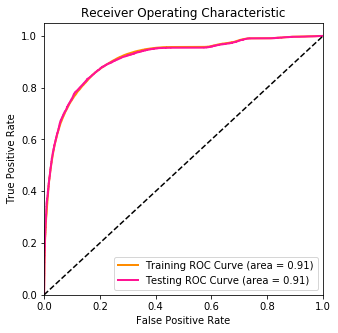

In [8]:
NN_mode  = fit_and_roc('ann',X_train, y_train, X_valid, y_valid)

## Predict renewal probability of test set

In [9]:
df_test = pd.read_csv('processed_test.csv')

In [10]:
X_test = df_test.drop('id',1).as_matrix()
X_test_scaled = scaler.transform(X_test)

In [11]:
result = NN_mode.predict(X_test_scaled)
df_test['renewal'] = result

In [12]:
result_proba = NN_mode.predict_proba(X_test_scaled)
df_test['renewal_proba'] = result_proba

In [13]:
df_test.head(10)

,perc_premium_paid_by_cash_credit,age_in_days,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,premium,logIncome,sourcing_channel_A,sourcing_channel_B,sourcing_channel_C,sourcing_channel_D,sourcing_channel_E,residence_area_type_Rural,residence_area_type_Urban,id,renewal,renewal_proba
0,0.001,27384.0,0.0,0.0,0.0,99.890000,7.0,3300.0,4.708846,1.0,0.0,0.0,0.0,0.0,1.0,0.0,649,0.980577,0.980577
1,0.124,23735.0,0.0,0.0,0.0,98.930000,19.0,11700.0,5.455058,1.0,0.0,0.0,0.0,0.0,0.0,1.0,81136,0.961035,0.961035
2,1.000,17170.0,0.0,0.0,0.0,99.020222,2.0,11700.0,5.269583,0.0,1.0,0.0,0.0,0.0,0.0,1.0,70762,0.598785,0.598785
3,0.198,16068.0,0.0,0.0,0.0,99.000000,11.0,5400.0,5.091808,0.0,1.0,0.0,0.0,0.0,1.0,0.0,53935,0.837183,0.837183
4,0.041,10591.0,1.0,0.0,0.0,99.170000,14.0,9600.0,5.301073,1.0,0.0,0.0,0.0,0.0,1.0,0.0,15476,0.511541,0.511541
5,0.112,16065.0,0.0,0.0,0.0,98.880000,7.0,11700.0,5.389396,0.0,1.0,0.0,0.0,0.0,1.0,0.0,64797,0.924580,0.924580
6,0.325,17167.0,6.0,0.0,0.0,99.000000,27.0,3300.0,5.588888,0.0,0.0,1.0,0.0,0.0,0.0,1.0,67412,0.064933,0.064933
7,0.362,20085.0,3.0,0.0,0.0,98.400000,14.0,5400.0,4.999479,1.0,0.0,0.0,0.0,0.0,0.0,1.0,44241,0.112115,0.112115
8,0.115,23008.0,0.0,0.0,0.0,99.880000,6.0,13800.0,5.556351,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5069,0.970826,0.970826
9,0.021,21906.0,0.0,0.0,0.0,99.890000,11.0,28500.0,5.707604,0.0,1.0,0.0,0.0,0.0,0.0,1.0,16615,0.985407,0.985407


## Optimize the incentives for each policy

In [14]:
def net_revenue_neg(incentive,proba,premium):
    effort = 10*(1-np.exp(-incentive/400))
    delta_p = 20*(1-np.exp(-effort/5))
    revenue = (proba+delta_p)*premium - incentive
    return -revenue

def constraint_1(incentive,proba):
    """
    final probability of renewal can't be larger than 1
    """
    effort = 10*(1-np.exp(-incentive/400))
    delta_p = 20*(1-np.exp(-effort/5))
    return 1- (proba + delta_p)

In [21]:
import scipy.optimize as optimize
x_start = 1650
bound = [(0,10000)]

opt_incent = np.zeros([df_test.shape[0],1])
for i,r in df_test.iterrows():
    # randomly choose x_start
    x_start = np.random.randint(low = 0, high=1000, size=1, dtype='l')
    constraints = ({'type': 'ineq', 'fun':  lambda x, proba = r.renewal_proba:  constraint_1(x,proba = r.renewal_proba)})
    opt_result = optimize.minimize(net_revenue_neg, x_start, args=(r.renewal_proba, r.premium),
                                   bounds = bound, constraints =  constraints, method='SLSQP')
    if opt_result['x']:
        opt_incent[i] = opt_result['x']
    else:
        opt_incent[i] = 0

In [22]:
pd.DataFrame(opt_incent).describe()

,0
count,34224.000000
mean,500.022269
std,289.530877
min,0.126170
25%,253.000000
50%,503.000000
75%,749.000000
max,999.000000


In [24]:
df_test['incentives'] = opt_incent

In [25]:
df_test[['id','renewal','incentives']].to_csv('result.csv',index = False)

In [23]:
sum(np.isnan(opt_incent))

array([0])